# Jacobian switching linear dynamical system (JSLDS) - 3-bit memory experiment

This notebook walks through the experimental results presented for the 3-bit memory experiment in the paper *Reverse engineering recurrent neural networks with Jacobian switching linear dynamical systems*.

### Imports

In [1]:
# Numpy, JAX, and Matplotlib should all be correctly installed and on the 
# python path.
import time
import jax
from jax.experimental import optimizers
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np             # original CPU-backed NumPy
from sklearn.decomposition import PCA

Clone the JSLDS repository

In [2]:
!git clone https://github.com/jimmysmith1919/JSLDS_public.git

Cloning into 'JSLDS_public'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 41 (delta 8), reused 37 (delta 7), pack-reused 0
Unpacking objects: 100% (41/41), done.


### Dependencies
To run this notebok you must import the following files:


*   model_and_training.py:  contains model and optimization code
*   nbit_memory_task.py:    functions to generate task inputs and targets
*   fixed_point_finding.py: functions to run the numerical fixed point finding
*   plotting.py:            some useful plotting functions



In [3]:
import JSLDS_public.JSLDS_code.model_and_training as JSLDS
import JSLDS_public.JSLDS_code.nbit_memory_task as nbit
import JSLDS_public.JSLDS_code.plotting as plotting
import JSLDS_public.JSLDS_code.fixed_point_finding as num_fps

# Jacobian Switching Linear Dynamical Systems
In this notebook we introduce the Jacobian Switching Linear Dynamical System (JSLDS). It combines ideas related to reverse engineering RNNs by linearizing around fixed points (Sussillo and Barak 2013) with switching linear dynamical systems (SLDS). From one points of view, our method allows for the automation of reconstructing the linearized dynamics in the reverse engineering process by providing a trained SLDS variant that switches about the nonlinear RNN's fixed points. From another point of view, our method allows for the generalization of the discrete swithcing of SLDS to continuous switching points.

## Motivation
Let $\mathbf{F}$ denote a nonlinear RNN with previous state $\mathbf{h}_{t-1}\in \mathbb{R}^D$, input $\mathbf{u}_t\in \mathbb{R}^U$, and parameters $\mathbf{\theta}$. Writing the RNN update equation and its first order Taylor series expansion around points $\mathbf{h}^*$ and $\mathbf{u}^*$ we have 

$\mathbf{h}_t = \mathbf{F}(\mathbf{h}_{t-1}, \mathbf{u}_t; \mathbf{\theta})$

$\ \ \  \approx \mathbf{F}(\mathbf{h}^*, \mathbf{u}^*; \mathbf{\theta}) + \frac{\partial\mathbf{F}}{\partial \mathbf{h}}(\mathbf{h}^*, \mathbf{u}^*; \mathbf{\theta})\left(\mathbf{h}_{t-1} - \mathbf{h}^*\right) + \frac{\partial\mathbf{F}}{\partial \mathbf{u}}(\mathbf{h}^*, \mathbf{u}^*; \mathbf{\theta})\left(\mathbf{u}_t-\mathbf{u}^*\right)$

Here, $\frac{\partial\mathbf{F}}{\partial \mathbf{h}}(\mathbf{h}^*, \mathbf{u}^*; \mathbf{\theta})\in \mathbb{R}^{DxD}$ is the **recurrent Jacobian** that determines the recurrent local dynamics and $\frac{\partial\mathbf{F}}{\partial \mathbf{u}}(\mathbf{h}^*, \mathbf{u}^*; \mathbf{\theta})\in \mathbb{R}^{DxU}$ is the **input Jacobian** that determines the system's input sensitivity.  If $\mathbf{h}^*$ are fixed points of $\mathbf{F}$ for a given $\mathbf{u}^*$, then $\mathbf{F}(\mathbf{h}^*, \mathbf{u}^*; \mathbf{\theta})=\mathbf{h}^*$ and the above equation yields

$\mathbf{h}_t- \mathbf{h}^* \approx \frac{\partial\mathbf{F}}{\partial \mathbf{h}}(\mathbf{h}^*, \mathbf{u}^*; \mathbf{\theta})\left(\mathbf{h}_{t-1} - \mathbf{h}^*\right) + \frac{\partial\mathbf{F}}{\partial \mathbf{u}}(\mathbf{h}^*, \mathbf{u}^*; \mathbf{\theta})\left(\mathbf{u}_t-\mathbf{u}^*\right)$

This gives a LDS that locally approximates $\mathbf{F}$ around $\mathbf{h}^*$.  In principle, if one knew how to select the correct fixed point and there was always a fixed point nearby, then one could use this equation to run a very accurate SLDS approximation of $\mathbf{F}$ by occasionally switching fixed points through time~$\{\mathbf{h}_1^*, \mathbf{h}_2^*, \cdots,\mathbf{h}_t^*\}$.  

Critically, the fixed point $\mathbf{{h}}_t^*$ indexes the recurrent Jacobian and input Jacobian in a manner analogous to how the discrete state $z_t$ indexes the matrices  $A^{(z_t)}$ and $V^{(z_t)}$ in a SLDS. In practice, selecting the correct fixed point in real-time is difficult to do which leads to the approach presented in the next section.

##The JSLDS Model
Our approach is to co-train an RNN, $\mathbf{F}$, with a novel SLDS formulation based on the Jacobian of $\mathbf{F}$ in the spirit of the motivation section above.  Specifically, we introduce a separate SLDS with its own hidden state $\mathbf{a}_t \in \mathbb{R}^D$ that switches around an expansion point $\mathbf{e}_t^* \in \mathbb{R}^D$:

$\mathbf{a}_t - \mathbf{e}_t^* = \frac{\partial\mathbf{F}}{\partial \mathbf{h}}(\mathbf{e}_t^*, \mathbf{u}^*; \mathbf{\theta})\left(\mathbf{a}_{t-1} - \mathbf{e}_t^*\right) + \frac{\partial\mathbf{F}}{\partial \mathbf{u}}(\mathbf{e}_t^*, \mathbf{u}^*; \mathbf{\theta})\left(\mathbf{u}_t-\mathbf{u}^*\right).$

Note that this equation shares its parameters $\theta$ with $\mathbf{F}$. We will generally take $\mathbf{u}^*$ to be either zero (the average value for examples) or the value of a context-dependent static input.  The goal is for $\mathbf{e}_t^*$ to be an approximate fixed point.  In order to accomplish this, we supplement the SLDS with a nonlinear auxiliary function $\mathbf{E}$ (the **expansion network**) with separate learned parameters $\mathbf{\phi}$: $\mathbf{e}_t^* = \mathbf{E}(\mathbf{a}_{t-1}; \mathbf{\phi}).$

The expansion network $\mathbf{E}$ returns the learned expansion points and is co-trained with the nonlinear RNN and the JSLDS.  Once trained, the goal is for this function to act as an approximate fixed point finder. For the experiments presented in this paper, we define $\mathbf{E}$ as a 2-layer multilayer perceptron (MLP) with the same dimension per layer as the state dimension of the RNN. 

These two equations define the JSLDS model, which can be run forward in time independent of the original nonlinear RNN. Given the previous state $\mathbf{a}_{t-1}$, the expansion network $\mathbf{E}$ uses this state to select the next expansion point $\mathbf{e}_t^*$ the system should switch around. The system then uses $\mathbf{e}_t^*$ to define the current state update equation by plugging its value into the recurrent Jacobian and input Jacobian of the original nonlinear RNN $\mathbf{F}$. Assuming the expansion network has learned to find fixed points, switching about the points $\mathbf{e}_t^*$ corresponds to reverse engineering nonlinear RNNs using fixed points. The dependence of the expansion point $\mathbf{e}_t^*$ exclusively on the previous state of the network $\mathbf{a}_{t-1}$ links to the recurrent connection in RSLDSs (Linderman 2017). 


Note that the JSLDS update equation is intended to closely follow the dynamics of $\mathbf{F}$, and we will enforce this in the training procedure. 

## JSLDS co-training procedure

We co-train together the nonlinear RNN and the JSLDS.  Each network can be run forward and solve the task independently. We pass each of their states through the same output activation function to create two loss functions, $\mathcal{L}_{\mathsf{RNN}}$ and $\mathcal{L}_{\mathsf{JSLDS}}$, for the RNN and JSLDS, respectively. In addition, the expansion points should approximate fixed points of $\mathbf{F}$ in order to achieve a good JSLDS approximation of the RNN. We also need to ensure the JSLDS states $\mathbf{a}_t$ approximate the RNN states $\mathbf{h}_t$. We achieve these goals by adding to the total loss function a fixed point regularizer $R_e$ and an approximation regularizer $R_a$ defined as 

$R_e(\theta, \phi) = \sum_t \left\|\mathbf{e}_t^* - \mathbf{F}(\mathbf{e}_t^*, \mathbf{u}^*; \mathbf{\theta})  \right\|_2^2$

$R_a(\theta, \phi) = \sum_t \left\|\mathbf{a}_t - \mathbf{h}_t\right\|_2^2$

Now we define the total training loss as 
$\mathcal{L}(\theta, \phi) = \lambda_{\mathsf{RNN}} \mathcal{L}_{\mathsf{RNN}}(\theta) +\lambda_{\mathsf{JSLDS}} \mathcal{L}_{\mathsf{JSLDS}}(\theta, \phi) +\lambda_e R_e(\theta, \phi)+\lambda_a R_a(\theta, \phi)$

where $\lambda_{\mathsf{RNN}}, \lambda_{\mathsf{JSLDS}}, \lambda_e$ and $\lambda_a$ control the strengths of the RNN loss, the JSLDS loss, the fixed point regularizer and the approximation regularizer, respectively. We optimize parameters $\mathbf{\theta}$ and $\mathbf{\phi}$ toghether at the same time (we do not alternate) using standard backpropagation through time (BPTT) methods for RNNs. Assuming the optimization goes well, the result will be two different systems trained to solve the task independently, with the JSLDS approximating the nonlinear RNN to first order. 


##Try it out

### Reload or train new model?
The following file contains the trained JSLDS/cotrained RNN weights used for the plots in the paper:

* JSLDS_public/JSLDS_code/trained_params_jslds_nbit_memory_weights_used_for_paper_plots.npz

The following file contains the trained standard GRU weights used for the plots in the paper:

* JSLDS_public/JSLDS_code/trained_params_jslds_nbit_memory_0.000413_2021-04-28_20_08_37.npz

If you would like to load trained model weights set reload_trained_model = True and set the network path to the corresponding file name. If you would like to train a new model set this variable to False.

In [4]:
reload_trained_model = True

### 3-bit memory task definition

In [5]:
# Nbit memory parameters
ntimesteps = 25
p = 0.3
flip_prob = np.array([(p / 2), (1 - p), (p / 2)])
nmem_inputs = 3
u = nmem_inputs * 2
o = nmem_inputs     # Number of outputs in the RNN

input_params = (ntimesteps, nmem_inputs, flip_prob)
nbit_memory_build_partial = lambda skeys: nbit.nbit_memory_build_inputs_and_targets(input_params,skeys)
nbit_memory_build_inputs_and_targets_jit = jax.jit(nbit_memory_build_partial)
build_inputs_and_targets = nbit_memory_build_inputs_and_targets_jit
input_plot_batch = nbit.nbit_memory_plot_batch

#set u_star (input to expand around in taylor approximation) to zeros (average of the inputs)
jslds_rnn = JSLDS.jslds_rnn_x_star_is_zeros

### Use trained model
See the paper Appendix for the hyperparameters used for this model

In [6]:
if reload_trained_model:
    network_path = 'JSLDS_public/JSLDS_code/trained_params_jslds_nbit_memory_weights_used_for_paper_plots.npz'
    loaded_params = np.load(network_path, allow_pickle=True)
    params = loaded_params['arr_0'].item()

    batch_size = 256          # How many examples in each batch
    #If using trained model, do not change the following parameters
    n = 100             # Number of units in the RNN
    rnn_fun = JSLDS.gru
    rnn_hps = {'fun' : rnn_fun}  
    hps = { 'rnn' : rnn_hps}

### Train a new model




### JSLDS loss function hyperparameters
In general, we have found the JSLDS loss function strengths to be relatively easy to select, however there exists a variety of ways they can be configured. The following provides a general framework for how to think about these parameters:

* $\lambda_e$ should generally be relatively large. It should be prioritized higher than the other losses or regularizers since failing to find expansion points that are good approximations of the RNN's fixed points or slow points would defeat the main purpose of the method.
* $\lambda_a$ should be large enough to ensure a small error between the JSLDS states and the RNN states. However, for some tasks, one may need to balance tradeoffs between $R_a$ and the losses $\mathcal{L}_{\mathsf{RNN}}$ and $\mathcal{L}_{\mathsf{JSLDS}}$.
* For most of the experiments in this paper we set the loss strengths to $\lambda_{\mathsf{RNN}} = 1$ and $\lambda_{\mathsf{JSLDS}}=1$. For the 3-bit memory task, we observed slightly better performance by setting $\lambda_{\mathsf{RNN}} = 3$ and $\lambda_{\mathsf{JSLDS}}=1$.  Allowing for a slight bias towards the RNN performance on this task seemed to generally lead to an improved task performance for both the RNN and the JSLDS. However, other variations are possible.
* For example, setting $\lambda_{\mathsf{RNN}} = 1$ and $\lambda_{\mathsf{JSLDS}}=0$ might correspond to the goal of training  a nonlinear RNN to be more interpretable by not sacrificing the goals of $R_e$ and $R_a$ for the sake of JSLDS task performance. 
* In the other extreme, if one were just interested in training an SLDS, setting $\lambda_{\mathsf{RNN}} = 0$ and $\lambda_{\mathsf{JSLDS}}=1$ could provide benefits since the JSLDS learns to share parameters across expansion points.

If one is interested in training a normal RNN (with no JSLDS regularization) then set the hyperparameters to
*   $\lambda_e$ = 0.0
*   $\lambda_{\mathsf{RNN}}$ = 1.0
*   $\lambda_{\mathsf{JSLDS}}$= 0.0
*   $\lambda_a$ = 0.0 

In [7]:
 if not reload_trained_model:
    # These four HPS dictate how the JSLDS is trained up. 
    fp_reg = 100.0         # \lambda_e: fixed point regularizer strength
    out_nl_reg = 3.0       # \lambda_RNN: nonlinear RNN loss strength
    out_staylor_reg = 1.0  # \lambda_JSLDS: JSLDS loss strength
    taylor_reg = 10.0      # \lambda_a: hidden state approximation regularizer

General training hyperparameters

In [8]:
if not reload_trained_model:
    # RNN hyperparameters
    n = 100                      # Number of units in the RNN
    rnn_params_fun = JSLDS.gru_params
    rnn_fun = JSLDS.gru
    taylor_series_rnn_order = 1  # Taylor series expansion order

    i_factor = 1.0               # input scale
    h_factor = 0.9               # Scaling of the recurrent weight matrix
    recurrent_is_identity = False
    h_scale = 0.1          
    rnn_hps = {'u' : u, 'n' : n, 
               'recurrent_is_identity' : recurrent_is_identity, 
              'h_factor' : h_factor, 
              'h_scale' : h_scale, 'i_factor' : i_factor,
              'params_fun' : rnn_params_fun, 
              'fun' : rnn_fun, 'order' : taylor_series_rnn_order}  
    
    nlayers = 2     # of MLP layers
    hps = {'mlp' : {'nlayers' : nlayers, 'n' : n}, 
          'rnn' : rnn_hps, 
          'out' : {'u' : n, 'o' : o, 'i_factor' : 1.0}}


    # Optimization hyperparameters
    num_batchs = 40000        # Total number of batches to train on.
    batch_size = 256          # How many examples in each batch
    eval_batch_size = 1024    # Evaluation batch size
    step_size = 0.02          # initial learning rate
    decay_factor = 0.9999     # decay the learning rate this much
    max_grad_norm = 10.0      # max gradient norm before clipping
    adam_b1 = 0.9             # Adam parameters
    adam_b2 = 0.999
    adam_eps = 1e-1
    print_every = 500         # Print training information every so often

    l2_reg = 0.0             # amount of L2 regularization on the weights
 

    opt_hps = {'num_batches' : num_batchs, 'batch_size' : batch_size, 
              'eval_batch_size' : eval_batch_size, 'print_every' : print_every,
              'step_size' : step_size, 'decay_factor' : decay_factor, 
              'max_grad_norm' : max_grad_norm, 
              'out_nl_reg': out_nl_reg, 'out_staylor_reg' : out_staylor_reg,
              'l2_reg' : l2_reg, 'fp_reg' : fp_reg, 'taylor_reg' : taylor_reg, 
              'adam_b1' : adam_b1, 'adam_b2': adam_b2, 'adam_eps': adam_eps}



Run this next cell regardless if you are loading the trained model or training a new model. This cell defines the initial random seed, plots an example trial, and defines a useful function that will be used later. The first time running this cell may take a few minutes during the first jit call.

Seed: 1920


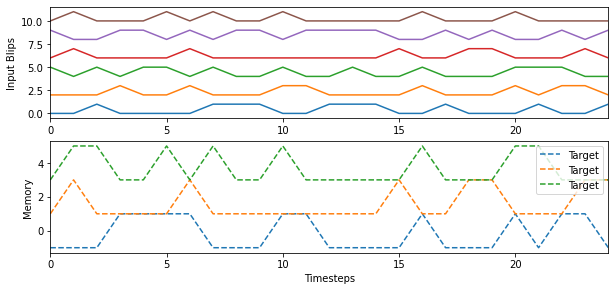

In [9]:
# Plot input/target example and define batch RNN function

seed = 1920
print("Seed: %d" % seed)
key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

# Plot input/target examples
ntoplot = 20    # how many example one could view 

key, skey = jax.random.split(key, 2)
skeys = jax.random.split(skey, ntoplot) # get ntoplot random keys
inputs, targets, masks = build_inputs_and_targets(skeys)
# Plot the input to the RNN and the target for the RNN.
input_plot_batch(ntimesteps, inputs, targets)


def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = \
        build_inputs_and_targets(keys)
    h0s_b = None # Use trained h0
    return inputs_b, targets_b, masks_b, h0s_b

#Define function to run the model on batches
batch_rnn_run = JSLDS.get_batch_rnn_run_fun(hps['rnn']['fun'], jslds_rnn)

This next cell is only necessary if you are training a new model. It initializes the model weights and plots the evaluation of the untrained networks on example trials using the initial random weights. It shows samples of the example inputs, sample JSLDS and RNN states (the approximation quality), sample expansion points and the RNN evaluated at the expansion points (the fixed point approximation quality), and sample JSLDS and RNN outputs compared to the target.

In [10]:
if not reload_trained_model:
    # Init some parameters for training.
    key, subkey = jax.random.split(key, 2)
    init_params = JSLDS.jslds_rnn_params(subkey, **hps)
    rnn_run = lambda inputs: batch_rnn_run(init_params, inputs)

    key, skey = jax.random.split(key)
    rnn_internals = JSLDS.run_trials(rnn_run, inputs_targets_no_h0s, 
                                     1, 16, skey)
    key, skey = jax.random.split(key)
    plotting.plot_examples(ntimesteps, rnn_internals, skey, nexamples=4)

This next cell is only necessary if you are training a new model. It defines and plots the learning rate decay function.

In [11]:
if not reload_trained_model:
    # Create a decay function for the learning rate
    decay_fun = optimizers.exponential_decay(opt_hps['step_size'], 
                                            decay_steps=1, 
                                            decay_rate=opt_hps['decay_factor'])

    plt.figure()
    plt.subplot(111)
    batch_idxs = np.linspace(1, num_batchs)
    plt.plot(batch_idxs, [decay_fun(b) for b in batch_idxs])
    plt.axis('tight')
    plt.xlabel('Batch number')
    plt.title('Learning rate');

Run this cell to train a new JSLDS-RNN system. Should take ~30-60 minutes using Colab GPU

In [12]:
if not reload_trained_model:
    # Run the optimization loop, first jit'd call will take a few minutes.
    all_train_losses = []

    opt_init, opt_update, opt_get_params = \
        optimizers.adam(decay_fun, opt_hps['adam_b1'], opt_hps['adam_b2'], 
                        opt_hps['adam_eps'])
    opt_state = opt_init(init_params)
    start_time = time.time()


    for batch_idx in range(num_batchs):
        key, skey = jax.random.split(key)
        skeys = jax.random.split(skey, batch_size)
        inputs, targets, masks = build_inputs_and_targets(skeys)
        opt_state = JSLDS.update_w_gc_jit(batch_idx, opt_state, opt_update, 
                                          opt_get_params, inputs,
                                    targets, masks, opt_hps['max_grad_norm'], 
                                    opt_hps['out_nl_reg'], opt_hps['out_staylor_reg'],
                                    opt_hps['taylor_reg'], opt_hps['fp_reg'], 
                                    opt_hps['l2_reg'], 
                                    hps['rnn']['fun'], jslds_rnn)
        if batch_idx % print_every == 0:
            params = opt_get_params(opt_state)
            all_train_losses.append(JSLDS.loss_jit(params, inputs, targets, 
                                                   masks,
                                            opt_hps['out_nl_reg'],
                                            opt_hps['out_staylor_reg'],
                                            opt_hps['taylor_reg'], 
                                            opt_hps['fp_reg'], 
                                            opt_hps['l2_reg'], 
                                            hps['rnn']['fun'], jslds_rnn))
            train_loss = all_train_losses[-1]['total']
            batch_time = time.time() - start_time
            step_size = decay_fun(batch_idx)
            s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
            print(s.format(batch_idx, batch_time, step_size, train_loss))
            start_time = time.time()
            
    # List of dicts to dict of lists
    all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Plot the training results

In [13]:
if not reload_trained_model:
    # Show the loss through training.
    x = np.arange(0, num_batchs, print_every)
    for xl1,xl2 in [(1000, num_batchs), (6000, num_batchs)]:
        xl1 = int(xl1/print_every)
        xl2 = int(xl2/print_every)

        plt.figure(figsize=(16,8))
        plt.subplot(231)
        plt.plot(x[xl1:xl2], all_train_losses['total'][xl1:xl2], 'k')
        plt.title('Total')

        plt.subplot(232)
        plt.plot(x[xl1:xl2], all_train_losses['lms_jslds'][xl1:xl2], 'r')
        plt.plot(x[xl1:xl2], all_train_losses['lms_nl'][xl1:xl2], 'r--')

        plt.legend(('JSLDS', 'RNN'))
        plt.title('Least mean square')

        plt.subplot(233)

        plt.plot(x[xl1:xl2], all_train_losses['l2'][xl1:xl2], 'g');
        plt.title('L2 regularization')

        plt.subplot(234)
        plt.plot(x[xl1:xl2], all_train_losses['fixed_point'][xl1:xl2], 'c');
        plt.title('Fixed point regularization')

        plt.subplot(235)
        plt.plot(x[xl1:xl2], all_train_losses['taylor'][xl1:xl2], 'm');
        plt.title('Taylor series regularization')


        plt.subplot(236)
        plt.plot(x[xl1:xl2], all_train_losses['total'][xl1:xl2], 'k')
        plt.plot(x[xl1:xl2], all_train_losses['lms_jslds'][xl1:xl2], 'r')
        plt.plot(x[xl1:xl2], all_train_losses['lms_nl'][xl1:xl2], 'r--')
        plt.plot(x[xl1:xl2], all_train_losses['l2'][xl1:xl2], 'g')
        plt.plot(x[xl1:xl2], all_train_losses['fixed_point'][xl1:xl2], 'c')
        plt.plot(x[xl1:xl2], all_train_losses['taylor'][xl1:xl2], 'm')
        plt.title('All losses');

Evaluate loss on a held-out set of trials. This can be computed for the uploaded trained model or the newly trained model. 

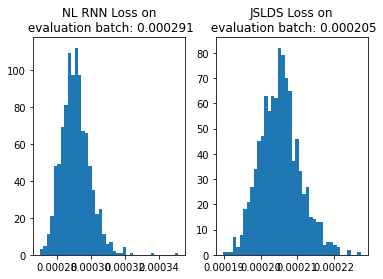

In [14]:
# Take a batch for an evaluation loss, notice all penalties are 0 for 
#the evaluation, except for the relevant task penalty

if not reload_trained_model:
    params = opt_get_params(opt_state)

key, skey = jax.random.split(key)

ntries = 1000
eval_losses = np.zeros(ntries)
eval_losses_j = np.zeros(ntries)
for try_idx in range(ntries):
    key, subkey = jax.random.split(key, 2)
    skeys = jax.random.split(subkey, batch_size)
    inputs, targets, masks = build_inputs_and_targets(skeys)
    eval_loss = JSLDS.loss_jit(params, inputs, targets, masks,
                         1.0,
                         0.0,
                         0.0, 0.0, 0.0, 
                         hps['rnn']['fun'], jslds_rnn)['total']
    eval_losses[try_idx] = eval_loss
    eval_loss_j = JSLDS.loss_jit(params, inputs, targets, masks,
                      0.0,
                      1.0,
                      0.0, 0.0, 0.0, 
                      hps['rnn']['fun'],jslds_rnn)['total']
    eval_losses_j[try_idx] = eval_loss_j


plt.subplot(121)
eval_loss_mean = np.mean(eval_losses)
eval_loss_str = "{:.6f}".format(eval_loss_mean)
plt.title("NL RNN Loss on\n evaluation batch: %s" % (eval_loss_str))    
plt.hist(eval_losses, 40);

plt.subplot(122)
eval_loss_mean_j = np.mean(eval_losses_j)
eval_loss_str_j = "{:.6f}".format(eval_loss_mean_j)
plt.title("JSLDS Loss on\n evaluation batch: %s" % (eval_loss_str_j))    
plt.hist(eval_losses_j, 40);

Compare the loss of the co-trained nonlinear RNN (left) and the JSLDS (right)

### Visualizations of trained JSLDS-RNN system

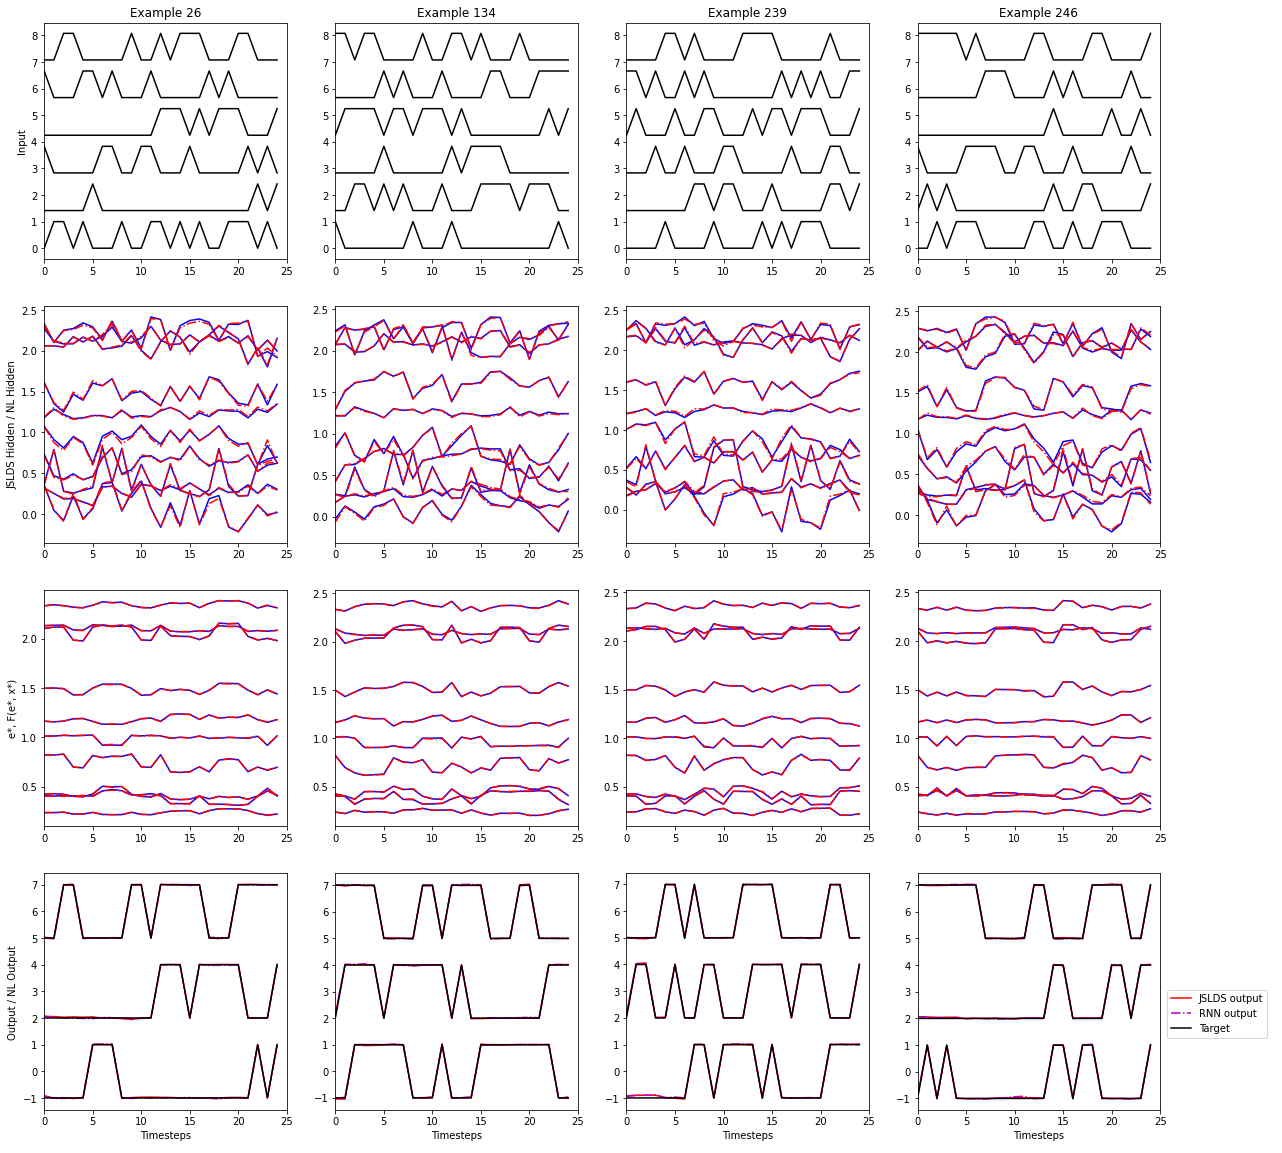

In [15]:
# Visualize how well the trained models perform.

rnn_run = lambda inputs: batch_rnn_run(params, inputs)


key, skey = jax.random.split(key)
rnn_internals = JSLDS.run_trials(rnn_run, inputs_targets_no_h0s, 1, batch_size, skey)

key, skey = jax.random.split(key)
plotting.plot_examples(ntimesteps, rnn_internals, skey, nexamples=4)

In [16]:
#Helpful functions for viewing the results
def get_apply_readout(params):
  def apply_readout(states_dn):
    return (np.dot(params['out']['W'], states_dn.T) + 
            np.expand_dims(params['out']['b'], axis=1)).T
  return apply_readout


def readout_plot_settings(ax, title, axlabel1, axlabel2, axlabel3, fs):
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    ax.legend(loc='upper right',prop={'size': fs}, frameon=False)
    ax.set_xlabel(axlabel1, fontsize=fs)
    ax.set_ylabel(axlabel2, fontsize=fs)
    ax.set_zlabel(axlabel3, fontsize=fs)
    ax.set_title(title, fontsize=fs)
    return ax


def pca_plot_settings(ax,fs):
    ax.set_xlabel('PC #1', fontsize=fs)
    ax.set_ylabel('PC #2', fontsize=fs)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='lower left',fontsize=fs, frameon=False)

### JSLDS/Co-trained RNN output trajectories in readout space

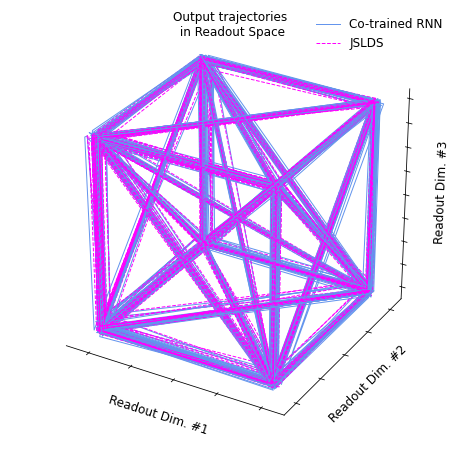

In [17]:
apply_readout = get_apply_readout(params)

fs = 12
jslds_color='magenta'
rnn_color = 'cornflowerblue'
rnn_linewidth = 1
jslds_linewidth = 1

ntoplot = 100
hiddens = np.reshape(rnn_internals['hiddens'][:ntoplot], (-1, n))
nl_hiddens = np.reshape(rnn_internals['nl_hiddens'][:ntoplot], (-1, n))

h_readout = apply_readout(hiddens)
nlh_readout = apply_readout(nl_hiddens)
axlabel1 = 'Readout Dim. #1'
axlabel2 = 'Readout Dim. #2'
axlabel3 = 'Readout Dim. #3'
title = 'Output trajectories\n in Readout Space'
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

nexamples = ntoplot
for eidx in range(nexamples):
    start_idx = eidx * ntimesteps
    stop_idx = (eidx + 1) * ntimesteps
    ax.plot3D(nlh_readout[start_idx:stop_idx,0], nlh_readout[start_idx:stop_idx,1], 
              nlh_readout[start_idx:stop_idx,2], color=rnn_color, 
              linewidth = rnn_linewidth)
    
    ax.plot3D(h_readout[start_idx:stop_idx,0], h_readout[start_idx:stop_idx,1], 
              h_readout[start_idx:stop_idx,2], '--', color=jslds_color, 
              linewidth=jslds_linewidth)

ax.plot3D(nlh_readout[start_idx:stop_idx,0], nlh_readout[start_idx:stop_idx,1], 
          nlh_readout[start_idx:stop_idx,2], label='Co-trained RNN',
          color=rnn_color,linewidth = rnn_linewidth)
ax.plot3D(h_readout[start_idx:stop_idx,0], h_readout[start_idx:stop_idx,1], 
          h_readout[start_idx:stop_idx,2], '--', color=jslds_color, 
          label='JSLDS', linewidth=jslds_linewidth)

readout_plot_settings(ax, title, axlabel1, axlabel2, axlabel3, fs)

### JSLDS Expansion points in readout space

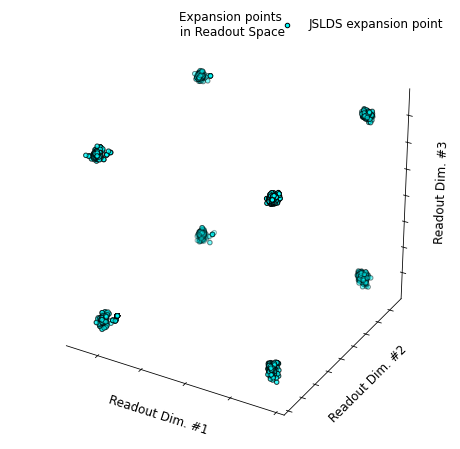

In [18]:
exp_color = 'cyan'
rnn_linewidth = 1.4
jslds_linewidth = 1.2

ntoplot = 100
hstars = np.reshape(rnn_internals['h_stars'][:ntoplot], (-1, n))

hstar_readout = apply_readout(hstars)
axlabel1 = 'Readout Dim. #1'
axlabel2 = 'Readout Dim. #2'
axlabel3 = 'Readout Dim. #3'
title = 'Expansion points\n in Readout Space'

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
emax = h_readout.shape[0]
ax.scatter(hstar_readout[:emax,0], hstar_readout[:emax,1], hstar_readout[:emax,2], 
            s=20, color=exp_color,label='JSLDS expansion point', 
           edgecolors='black',zorder=0);

readout_plot_settings(ax, title, axlabel1, axlabel2, axlabel3,fs)

The expansion points have learned to cluster around 8 marginally stable (determined by eigenvalue analysis below) fixed points of the nonlinear RNN. (See comparison with numerical fixed points below for verification.)

For any trial, we can analyze eigenvalues of JSLDS at any point in its state space by
computing an eigendecomposition of the co-trained RNN's recurrent Jacobian 
at corresponding expansion point. 

In [19]:
#Compute Jacobian at each expansion point for a given trial

trial = 5 #trial from evaluation trials of size batch_size

x_star = np.zeros(u)
rnn_fun_h = lambda h : rnn_fun(params['rnn'], h, x_star)


#Compute recurrent Jacobians
hstar_jac = num_fps.compute_jacobians(rnn_fun_h, rnn_internals['h_stars'][trial]
                                      )

#Compute eigenvalue decompositions
hstar_eig_decomps = num_fps.compute_eigenvalue_decomposition(hstar_jac,
                                                             'magnitude')

Top ten eigenvalues:
 [1.0167764 +0.j         0.999716  +0.j         0.94187945+0.j
 0.89745843+0.j         0.81447625+0.j         0.77151614+0.01731665j
 0.77151614-0.01731665j 0.71935266+0.05813595j 0.71935266-0.05813595j
 0.7181192 -0.01417159j]


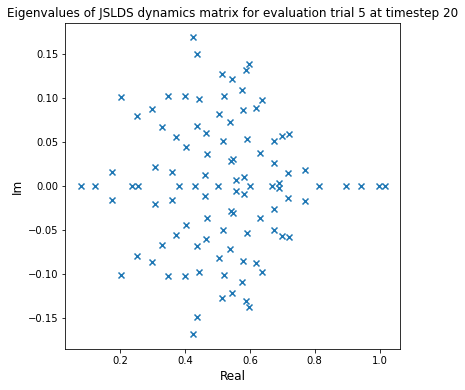

In [20]:
#Plot eigenvalues in complex plane for specific timestep of trial
timestep = 20

plt.figure(figsize=(6,6))
example = hstar_eig_decomps[timestep]['evals'][:]
X = [x.real for x in example]
Y = [x.imag for x in example]
plt.scatter(X,Y, marker='x', alpha=1)
plt.xlabel('Real', fontsize=fs)
plt.ylabel('Im', fontsize=fs)
plt.title('Eigenvalues of JSLDS dynamics matrix for evaluation trial {} at timestep {}'.format(trial, timestep))

print('Top ten eigenvalues:\n', hstar_eig_decomps[timestep]['evals'][:10])

### JSLDS approximation of co-trained RNN's dynamics

Here we evaluate the JSLDS approximation of the co-trained nonlinear RNN's dynamics. We first display example trajectories projected into PCA space. Note the JSLDS states were computed by running the JSLDS forward in time for the entire trial trajectory, as opposed to needing to resort to one-step ahead dynamics generation.

In [21]:
#Compute PCA
pca = PCA(n_components=2).fit(rnn_internals['nl_hiddens'].reshape(-1,n))
h_pca = pca.transform(rnn_internals['hiddens'].reshape(-1,n))
nlh_pca = pca.transform(rnn_internals['nl_hiddens'].reshape(-1,n))

Text(0.5, 1.0, 'Trial 11 JSLDS dynamics generation')

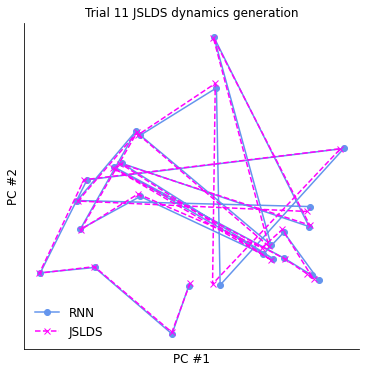

In [22]:
#Plot PCA trajectories for example trial
trial = 11
plt.figure(figsize=(6,6))
start_idx = trial*25
stop_idx = trial*25+25

ax=plt.subplot(111)


ax.plot(nlh_pca[start_idx:stop_idx,0], nlh_pca[start_idx:stop_idx,1], '-o', 
        color='cornflowerblue', label='RNN')
ax.plot(h_pca[start_idx:stop_idx,0], h_pca[start_idx:stop_idx,1], '--x', 
        color='magenta', label='JSLDS')
pca_plot_settings(ax,fs)
plt.title('Trial {} JSLDS dynamics generation'.format(trial), fontsize=fs)

Now compute the mean relative error,$\|\mathbf{h}_{t}^{\textsf{RNN}}-\mathbf{h}_t^{\textsf{lin}} \|_2/\|\mathbf{h}_t^{\textsf{RNN}} \|_2$,  for the approximation on a batch of held-out evaluation trials. For the JSLDS, $\mathbf{h}_t^{\textsf{lin}}$ is just the JSLDS states, $\mathbf{a}_t$, generated for the trial trajectories.

In [23]:
from jax import vmap

def rel_error_t(h_apprx, h_true):
  def norm_diff(h_apprx, h_true):
    return jnp.linalg.norm(h_apprx-h_true, ord=2)
  return norm_diff(h_apprx, h_true)/jnp.linalg.norm(h_true, ord=2)

def rel_error(h_apprxs, h_trues):
  def rel_error_series(h_apprxs, h_trues):
    return vmap(rel_error_t, (0,0))(h_apprxs, h_trues)

  return np.mean(vmap(rel_error_series, (0,0))(h_apprxs, h_trues))



In [24]:
#Compute relative error of JSLDS linearized approximation
mean_rel_err  = rel_error(rnn_internals['hiddens'], rnn_internals['nl_hiddens'])
print('JSLDS heldout mean relative error', mean_rel_err)

JSLDS heldout mean relative error 0.04646045


### Numerically find the fixed points of the co-trained RNN for verification.

Now we use the numerical fixed point finding method to check that the expansion points learned by the JSLDS approximate the co-trained RNN's fixed points.

Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-500 in 1.49 sec, Step size: 0.77875, Training loss 0.00003
    Batches 501-1000 in 0.68 sec, Step size: 0.60645, Training loss 0.00002
    Batches 1001-1500 in 0.68 sec, Step size: 0.47228, Training loss 0.00001
    Batches 1501-2000 in 0.67 sec, Step size: 0.36779, Training loss 0.00001
    Batches 2001-2500 in 0.67 sec, Step size: 0.28642, Training loss 0.00001
    Batches 2501-3000 in 0.68 sec, Step size: 0.22305, Training loss 0.00001
    Batches 3001-3500 in 0.67 sec, Step size: 0.17370, Training loss 0.00001
    Batches 3501-4000 in 0.67 sec, Step size: 0.13527, Training loss 0.00001
    Batches 4001-4500 in 0.67 sec, Step size: 0.10534, Training loss 0.00001
    Batches 4501-5000 in 0.68 sec, Step size: 0.08203, Training loss 0.00001
    Batches 5001-5500 in 0.68 sec, Step size: 0.06388, Training loss 0.00001
    Batches 5501-6000 in 0.67 sec, Step size: 0.04975, Training loss 0.00001
    Batc

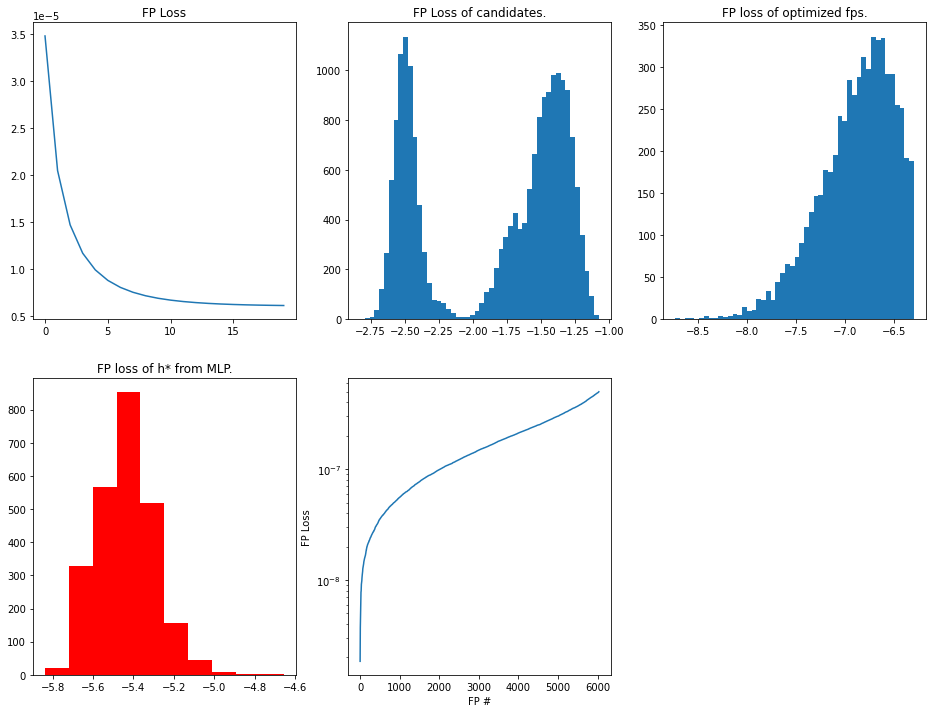

In [25]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000     # Total number of batches to train on.
fp_batch_size = 128        # How many examples in each batch
fp_step_size = 1.0         # initial learning rate
fp_decay_factor = 0.9995   # decay the learning rate this much
fp_decay_steps = 1         
fp_adam_b1 = 0.9           # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5

fp_noise_var = 0.01        # Gaussian noise added to fixed point candidates
fp_opt_print_every = 500   # Print training information during optimiziation 
fp_opt_stop_tol = 0.0
fp_tol = 0.0000005

fp_unique_tol = 0.0         # tolerance for determination of identical fixed pts
fp_outlier_tol = np.inf     # define outlier tolerance

fp_opt_hps = {'num_batches' : fp_num_batches, 'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 
              'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : fp_opt_stop_tol, 
              'fp_tol' : fp_tol, 'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}

x_star = np.zeros(u)
rnn_fun_h = lambda h : rnn_fun(params['rnn'], h, x_star)


batch_rnn_fun_h = jax.vmap(rnn_fun_h, in_axes=(0,))
fp_loss_fun = num_fps.get_fp_loss_fun(rnn_fun_h)
total_fp_loss_fun = num_fps.get_total_fp_loss_fun(rnn_fun_h)


fp_candidates1 = np.reshape(rnn_internals['h_stars'], (-1, n))
fp_candidates2 = np.reshape(rnn_internals['hiddens'], (-1, n))
fp_candidates3 = np.reshape(rnn_internals['nl_hiddens'], (-1, n))
fp_candidates = np.concatenate([fp_candidates1, fp_candidates2, fp_candidates3], 
                               axis=0)

fps, fp_losses, fp_idxs, fp_opt_details = \
    num_fps.find_fixed_points(rnn_fun_h, fp_candidates, fp_opt_hps, 
                              do_print=True)


plt.figure(figsize=(16,12))
plt.subplot(231)
plt.plot(fp_opt_details['fp_losses'])
plt.title('FP Loss')
plt.subplot(232)
plt.hist(np.log10(fp_loss_fun(fp_candidates)), 50)
plt.title('FP Loss of candidates.')
plt.subplot(233)
plt.hist(np.log10(fp_loss_fun(fps)), 50);
plt.title('FP loss of optimized fps.')
plt.subplot(234)
plt.hist(np.log10(fp_loss_fun(hstars)), color='r');
plt.title('FP loss of h* from MLP.');
plt.subplot(235)
plt.semilogy(fp_losses)
plt.xlabel('FP #')
plt.ylabel('FP Loss');

Now project the numerical fixed points into the readout space to compare to the expansion points

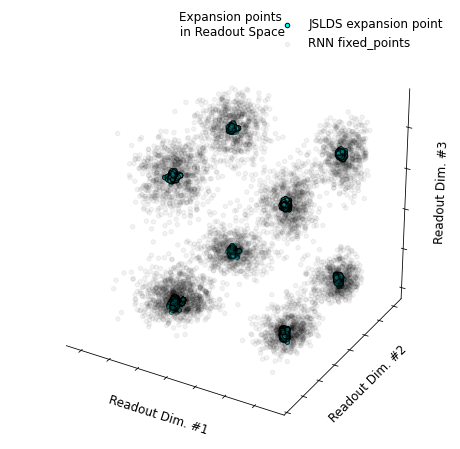

In [26]:
exp_color = 'cyan'
rnn_linewidth = 1.4
jslds_linewidth = 1.2

ntoplot = 256
hstars = np.reshape(rnn_internals['h_stars'][:ntoplot], (-1, n))


hstar_readout = apply_readout(hstars)
fps_readout  = apply_readout(fps)
axlabel1 = 'Readout Dim. #1'
axlabel2 = 'Readout Dim. #2'
axlabel3 = 'Readout Dim. #3'
title = 'Expansion points\n in Readout Space'


fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')



emax = h_pca.shape[0]
ax.scatter(hstar_readout[:emax,0], hstar_readout[:emax,1], hstar_readout[:emax,2], 
            s=20, color=exp_color,label='JSLDS expansion point',
            edgecolors='black',zorder=0);
es = np.arange(fps.shape[0])
ax.scatter(fps_readout[es,0], fps_readout[es,1], fps_readout[es,2], 
            s=20, color='k',label='RNN fixed_points', alpha=0.05);

readout_plot_settings(ax, title, axlabel1, axlabel2, axlabel3,fs)

We see the expansion points provide a good approximation of the the co-trained RNN's fixed points.

### Compare to standard GRU

Load trained standard GRU trained without JSLDS

In [27]:
network_path = 'JSLDS_public/JSLDS_code/trained_params_jslds_nbit_memory_0.000413_2021-04-28_20_08_37.npz'
loaded_params2 = np.load(network_path, allow_pickle=True)
params2 = loaded_params2['arr_0'].item()

Evaluate loss on a held-out set of trials.

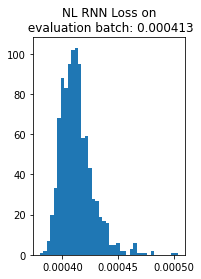

In [28]:
key, skey = jax.random.split(key)

ntries = 1000
eval_losses = np.zeros(ntries)
for try_idx in range(ntries):
    key, subkey = jax.random.split(key, 2)
    skeys = jax.random.split(subkey, batch_size)
    inputs, targets, masks = build_inputs_and_targets(skeys)
    eval_loss = JSLDS.loss_jit(params2, inputs, targets, masks,
                         1.0,
                         0.0,
                         0.0, 0.0, 0.0, 
                         hps['rnn']['fun'], jslds_rnn)['total']
    eval_losses[try_idx] = eval_loss


plt.subplot(121)
eval_loss_mean = np.mean(eval_losses)
eval_loss_str = "{:.6f}".format(eval_loss_mean)
plt.title("NL RNN Loss on\n evaluation batch: %s" % (eval_loss_str))    
plt.hist(eval_losses, 40);

### Visualizations of standard trained GRU

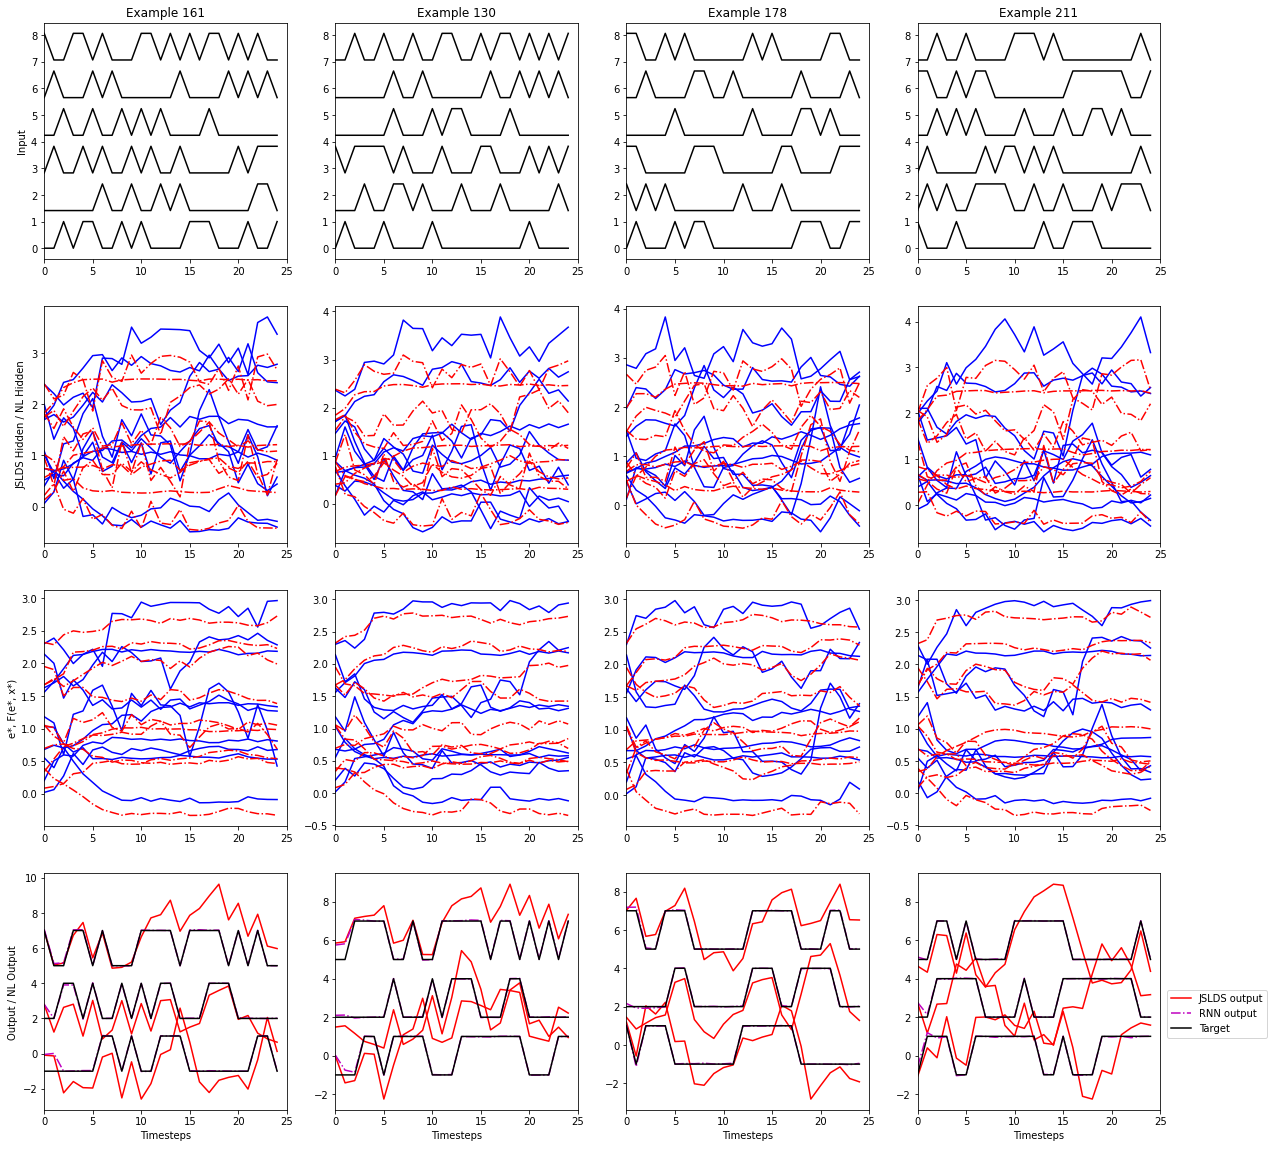

In [29]:
# Visualize how well the trained models perform.

rnn_run2 = lambda inputs: batch_rnn_run(params2, inputs)


key, skey = jax.random.split(key)
rnn_internals2 = JSLDS.run_trials(rnn_run2, inputs_targets_no_h0s, 1,
                                  batch_size, skey)

key, skey = jax.random.split(key)
plotting.plot_examples(ntimesteps, rnn_internals2, skey, nexamples=4)

Note the JSLDS output and approximations above are all bad since the standard GRU was not co-trained with the JSLDS. So only the RNN output lines are relevant.

### Numerically find the fixed points of the standard GRU.

Adding noise to fixed point candidates.
Optimizing to find fixed points.
    Batches 1-500 in 1.13 sec, Step size: 0.77875, Training loss 0.00013
    Batches 501-1000 in 0.68 sec, Step size: 0.60645, Training loss 0.00007
    Batches 1001-1500 in 0.68 sec, Step size: 0.47228, Training loss 0.00005
    Batches 1501-2000 in 0.67 sec, Step size: 0.36779, Training loss 0.00004
    Batches 2001-2500 in 0.67 sec, Step size: 0.28642, Training loss 0.00003
    Batches 2501-3000 in 0.67 sec, Step size: 0.22305, Training loss 0.00003
    Batches 3001-3500 in 0.68 sec, Step size: 0.17370, Training loss 0.00002
    Batches 3501-4000 in 0.67 sec, Step size: 0.13527, Training loss 0.00002
    Batches 4001-4500 in 0.68 sec, Step size: 0.10534, Training loss 0.00002
    Batches 4501-5000 in 0.67 sec, Step size: 0.08203, Training loss 0.00002
    Batches 5001-5500 in 0.67 sec, Step size: 0.06388, Training loss 0.00002
    Batches 5501-6000 in 0.67 sec, Step size: 0.04975, Training loss 0.00002
    Batc

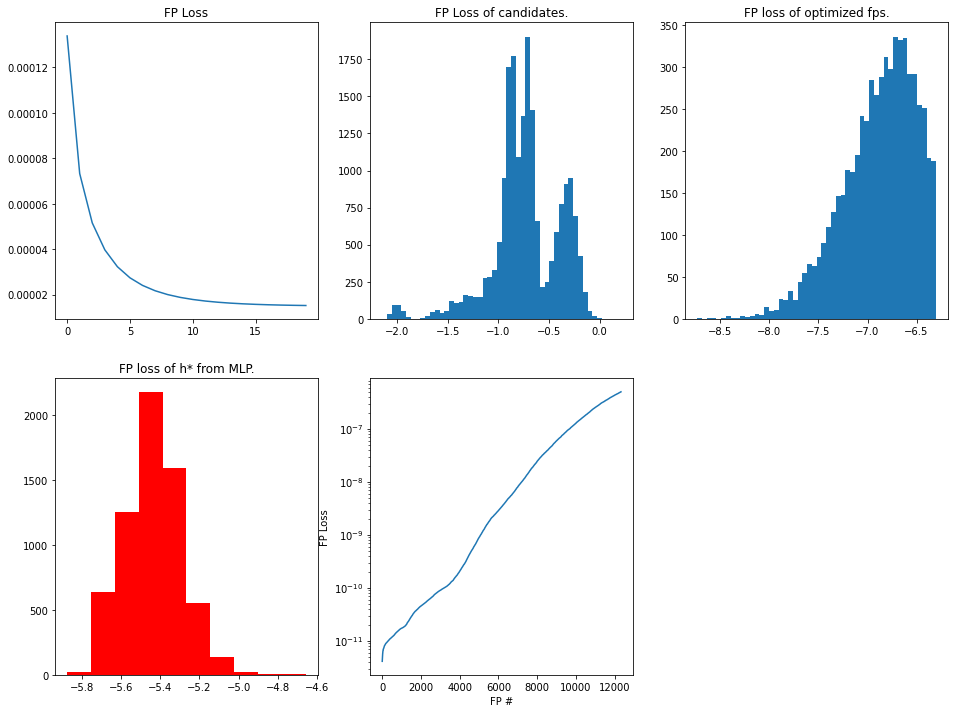

In [30]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000         # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 1.0          # initial learning rate
fp_decay_factor = 0.9995     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5

fp_noise_var = 0.01          # Gaussian noise added to fixed point candidates 
fp_opt_print_every = 500   # Print training information during optimziation 
fp_opt_stop_tol = 0.0
fp_tol = 0.0000005

fp_unique_tol = 0.0         # tolerance for determination of identical fixed pts
fp_outlier_tol = np.inf     # define outlier tolerance

fp_opt_hps = {'num_batches' : fp_num_batches, 'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 
              'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : fp_opt_stop_tol, 
              'fp_tol' : fp_tol, 'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}

x_star = np.zeros(u)
rnn_fun_h2 = lambda h : rnn_fun(params2['rnn'], h, x_star)


batch_rnn_fun_h = jax.vmap(rnn_fun_h2, in_axes=(0,))
fp_loss_fun = num_fps.get_fp_loss_fun(rnn_fun_h)
total_fp_loss_fun = num_fps.get_total_fp_loss_fun(rnn_fun_h)


fp_candidates1 = np.reshape(rnn_internals2['h_stars'], (-1, n))
fp_candidates2 = np.reshape(rnn_internals2['hiddens'], (-1, n))
fp_candidates3 = np.reshape(rnn_internals2['nl_hiddens'], (-1, n))
fp_candidates = np.concatenate([fp_candidates1, fp_candidates2, fp_candidates3], 
                               axis=0)


fps2, fp_losses, fp_idxs, fp_opt_details = \
    num_fps.find_fixed_points(rnn_fun_h2, fp_candidates, fp_opt_hps,
                              do_print=True)


plt.figure(figsize=(16,12))
plt.subplot(231)
plt.plot(fp_opt_details['fp_losses'])
plt.title('FP Loss')
plt.subplot(232)
plt.hist(np.log10(fp_loss_fun(fp_candidates)), 50)
plt.title('FP Loss of candidates.')
plt.subplot(233)
plt.hist(np.log10(fp_loss_fun(fps)), 50);
plt.title('FP loss of optimized fps.')
plt.subplot(234)
plt.hist(np.log10(fp_loss_fun(hstars)), color='r');
plt.title('FP loss of h* from MLP.');
plt.subplot(235)
plt.semilogy(fp_losses)
plt.xlabel('FP #')
plt.ylabel('FP Loss');

### Standard GRU  outputs and fixed points in readout space
Note the loop for this code block is a bit slow. You can speed it up by reducing the num_fps_to_plot variable. This reduces the number of fixed points randomly sampled from the numerical fixed points found above. Setting too low may prevent some of the important fixed point locations from being displayed.

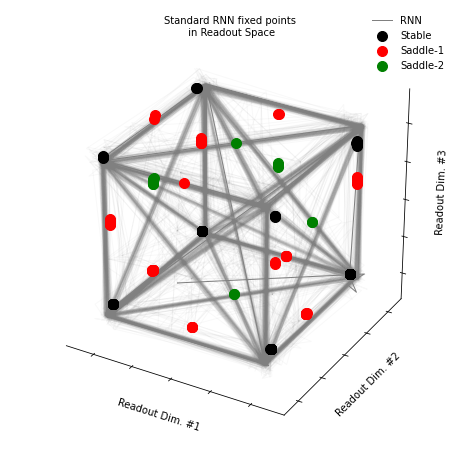

In [31]:
num_fps_to_plot  = 200 #thin out number shown since this block takes a while to 
                       #compute and plot
apply_readout2 = get_apply_readout(params2)

fs = 10
alpha=0.05

ms=100

rnn_color = 'gray'
rnn_linewidth = 1

ntoplot = 256
nl_hiddens2 = np.reshape(rnn_internals2['nl_hiddens'][:ntoplot], (-1, n))



nlh_readout2 = apply_readout2(nl_hiddens2)
fps_readout2 = apply_readout2(fps2)
axlabel1 = 'Readout Dim. #1'
axlabel2 = 'Readout Dim. #2'
axlabel3 = 'Readout Dim. #3'
title = 'Standard RNN fixed points\n in Readout Space'

fig = plt.figure(figsize=(8,8))

ax = plt.axes(projection='3d')


nexamples = ntoplot
for eidx in range(nexamples):
    start_idx = eidx * ntimesteps
    stop_idx = (eidx + 1) * ntimesteps
    ax.plot3D(nlh_readout2[start_idx:stop_idx,0], nlh_readout2[start_idx:stop_idx,1], 
              nlh_readout2[start_idx:stop_idx,2], color=rnn_color, 
              alpha=alpha,linewidth = rnn_linewidth)
    
ax.plot3D(nlh_readout2[start_idx:stop_idx,0], nlh_readout2[start_idx:stop_idx,1], 
          nlh_readout2[start_idx:stop_idx,2], label='RNN',alpha=1,
          color=rnn_color,linewidth = rnn_linewidth)


key, skey = jax.random.split(key)
es = jax.random.choice(skey, np.arange(fps2.shape[0]),
                       shape=(num_fps_to_plot,), replace=False) 


eps = 0.0
for i in es:
  uhstar_jac = num_fps.compute_jacobians(rnn_fun_h2, fps2[i][None,...])
  uhstar_eig_decomps = num_fps.compute_eigenvalue_decomposition(uhstar_jac, 
                                                                'real')
  decomp = uhstar_eig_decomps[0]

  
  if np.sum(decomp['evals'].real>(1+eps))==0:
      ax.scatter(fps_readout2[i,0], fps_readout2[i,1], fps_readout2[i,2], '*', 
      s=ms, color='black');

  elif np.sum(decomp['evals'].real>(1+eps))==1:
      ax.scatter(fps_readout2[i,0], fps_readout2[i,1], fps_readout2[i,2], '*', 
              s=ms, color='red');
  elif np.sum(decomp['evals'].real>(1+eps))==2:
      ax.scatter(fps_readout2[i,0], fps_readout2[i,1], fps_readout2[i,2], '*', 
              s=ms, color='green');


i=0
ax.scatter(fps_readout2[i,0], fps_readout2[i,1], fps_readout2[i,2], '*', 
        s=ms, color='black', label='Stable');
ax.scatter(fps_readout2[i,0], fps_readout2[i,1], fps_readout2[i,2], '*', 
              s=ms, color='red', label='Saddle-1');
ax.scatter(fps_readout2[i,0], fps_readout2[i,1], fps_readout2[i,2], '*', 
        s=ms, color='green', label='Saddle-2');

readout_plot_settings(ax, title, axlabel1, axlabel2, axlabel3,fs)



We observe the standard GRU learns a very different fixed point solution than the GRU co-trained with the JSLDS.

### Standard GRU linearized dynamics generation

To generate dynamics trajectories for a standard RNN, we have to linearize around the numerical fixed points. As discussed in the paper, since there is no exact link between the numerical fixed points and points in state space, we have to employ some decision criteria. Here we just choose the closest fixed point.

In [32]:
def get_nearest_fp(fps, ha_tm1):
  """Helper function to find the nearest fixed point to our current point 
  in state space"""
  euc_dists = np.sqrt(np.sum((fps-ha_tm1)**2, axis=1))
  return fps[np.argmin(euc_dists)]

#Compute pca on the standard GRU hidden states.
pca2 = PCA(n_components=2).fit(rnn_internals2['nl_hiddens'].reshape(-1,n))
h_pca2 = pca2.transform(rnn_internals2['nl_hiddens'].reshape(-1,n))

First, we try to fully simulate the dynamics forward for the entire trajectory.

Text(0.5, 1.0, 'Trial 7 Linearized approximation\n simulating dynamics forward')

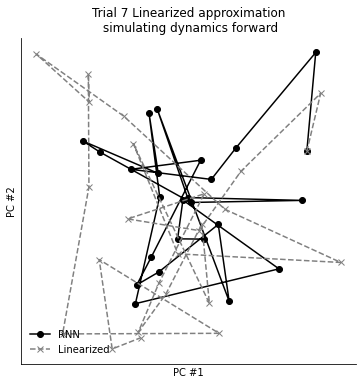

In [33]:
# try to run all the way
trial = 7
x_star = np.zeros(u)
h_approxs = np.zeros((ntimesteps, n))
ha_tm1 = rnn_internals2['nl_hiddens'][trial, 0] #start with intial RNN state
h_approxs[0] = ha_tm1
for i in range(1,ntimesteps):
  h_star = get_nearest_fp(fps2, ha_tm1) #get nearest fixed point
  ha_tm1= JSLDS.taylor_approx_rnn(rnn_fun, params2['rnn'], h_star, x_star, 
                                  ha_tm1, rnn_internals2['inputs'][trial,i], 1)
  h_approxs[i] = ha_tm1

h_approxs_pca = pca2.transform(h_approxs)


plt.figure(figsize=(6,6))
start_idx = trial*25
stop_idx = trial*25+25

ax=plt.subplot(111)
ax.plot(h_pca2[start_idx:stop_idx,0], h_pca2[start_idx:stop_idx,1], '-o',
        color='black', label='RNN')
ax.plot(h_approxs_pca[:,0], h_approxs_pca[:,1], '--x', color='gray', 
        label='Linearized')
pca_plot_settings(ax,fs)
plt.title('Trial {} Linearized approximation\n simulating dynamics forward'.format(trial))

We see that the linearized dynamics accumulate errors each timestep and for most trials  diverge significantly. So instead we resort to one-step ahead dynamics generation. For each state update of the trajectory, we provide the linearized state update equation the true previous state of the RNN. 

Text(0.5, 1.0, 'Trial 7 Linearized approximation\n one-step ahead dynamics generation')

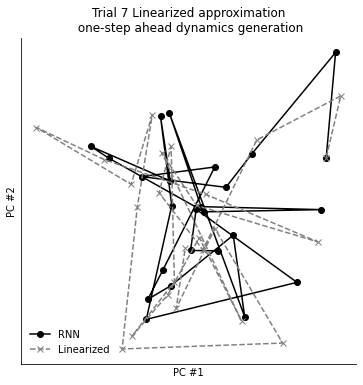

In [34]:
#One step ahead dynamics generation
trial = 7
x_star = np.zeros(u)
h_approxs = np.zeros((ntimesteps, n))
ha_tm1 = rnn_internals2['nl_hiddens'][trial, 0] #start with initial RNN state
h_approxs[0] = ha_tm1
for i in range(1,ntimesteps):
  h_star = get_nearest_fp(fps2, ha_tm1) #get nearest fixed point
  h_approxs[i] = JSLDS.taylor_approx_rnn(rnn_fun, params2['rnn'], h_star, 
                                         x_star, 
                                  ha_tm1, rnn_internals2['inputs'][trial,i], 1)
  ha_tm1 = rnn_internals2['nl_hiddens'][trial, i] #use true current state

h_approxs_pca = pca2.transform(h_approxs)


plt.figure(figsize=(6,6))
start_idx = trial*ntimesteps
stop_idx = trial*ntimesteps+ntimesteps

ax=plt.subplot(111)
ax.plot(h_pca2[start_idx:stop_idx,0], h_pca2[start_idx:stop_idx,1], '-o', 
        color='black', label='RNN')
ax.plot(h_approxs_pca[:,0], h_approxs_pca[:,1], '--x', color='gray',
        label='Linearized')
pca_plot_settings(ax,fs)
plt.title('Trial {} Linearized approximation\n one-step ahead dynamics generation'.format(trial))

This is better, but still not great compared to the JSLDS approximation (which fully simulates the dynamics forward) displayed above.

Now we compute the mean relative error of the one-step ahead dynamics approximation for an evaluation batch of held-out trials. This code block is a bit slow.

In [35]:
x_star = np.zeros(u)
h_approxs = np.zeros((batch_size, ntimesteps, n))

for b in range(batch_size):
    ha_tm1 = rnn_internals2['nl_hiddens'][b, 0] #start with initial RNN state
    h_approxs[b,0] = ha_tm1

    for i in range(1,ntimesteps):
      h_star = get_nearest_fp(fps2, ha_tm1) #get nearest fixed point
      h_approxs[b,i] = JSLDS.taylor_approx_rnn(rnn_fun, params2['rnn'], h_star, 
                                               x_star, 
                                      ha_tm1, rnn_internals2['inputs'][b,i], 1)
      ha_tm1 = rnn_internals2['nl_hiddens'][b, i] #use true current state

#don't include first state since it is given
#Compute relative error of JSLDS linearized approximation
mean_rel_err2  = rel_error(h_approxs[:,1:], rnn_internals2['nl_hiddens'][:,1:])
print('JSLDS mean relative error:          ', mean_rel_err)
print('Standard method mean relative error:', mean_rel_err2)

JSLDS mean relative error:           0.04646045
Standard method mean relative error: 0.26810342


We compare this one-step ahead linearized dynamics mean relative error for the standard method to the fully simulated JSLDS mean relative error (calculated earlier in this notebook). The JSLDS provides a large reduction in error and allows for simulating an entire trajectory accurately. For the paper we retrained both the JSLDS/co-trained RNN and the standard GRU 10 different times each from different random weight initializations and report the mean and standard deviation of the resulting mean relative error for each run.

### Appendix: Hidden state update mechanism

NOTE: the current code for this section will only work if reloading the trained JSLDS weights from the paper and if the initial random seed is not changed. This is because one needs to ensure all eight expansion points are analyzed, which requires manually finding timesteps of a trial trajectory where each of the different expansion points are used.  If one wishes to perform the same analysis for a new trained model or for a different random seeed, one should manually determine these indices by walking through a trial trajectory and update the code block below.

All 8 expansion point locations (the 8 corners) should be present in the plot below in order for the results presented below to be complete.

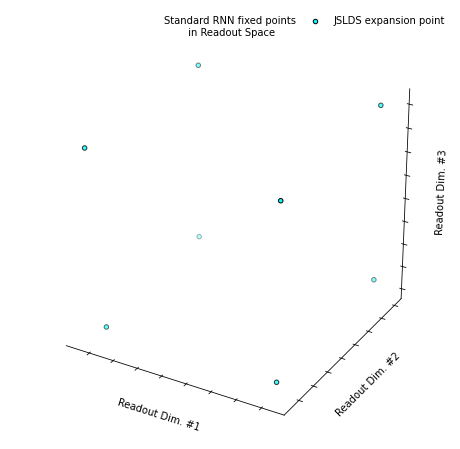

In [36]:
if reload_trained_model==True:
  hstars_8 = hstars[[0,4,6,8,9,10,19,21]] #You will need to change these 
                                          #indices if not reloading the 
                                          #trained weights from the paper 
  hstar8_readout = apply_readout(hstars_8)

  fig = plt.figure(figsize=(8,8))
  ax = plt.axes(projection='3d')
  emax = hstar8_readout.shape[0]
  ax.scatter(hstar8_readout[:emax,0], hstar8_readout[:emax,1], hstar8_readout[:emax,2], 
              s=20, color=exp_color,label='JSLDS expansion point', 
            edgecolors='black',zorder=0);


  readout_plot_settings(ax, title, axlabel1, axlabel2, axlabel3,fs)

These 8 marginally stable fixed points are used to dynamically select or ignore the inputs to update the hidden state. This can be observed by studying the top left eigenvectors of the recurrent Jacobian (which we will refer to as the selection vectors) at each of the 8 clusters and how they act upon the different possible effective inputs.  Here we compute the recurrent Jacobian and its eigenvalue decomposition at each of the 8 expansion points

In [37]:
if reload_trained_model==True:
  #Compute recurrent Jacobian at each expansion point

  x_star = np.zeros(u)
  rnn_fun_h = lambda h : rnn_fun(params['rnn'], h, x_star)
  df_dhs = num_fps.compute_jacobians(rnn_fun_h, hstars_8
                                        )
  df_dh_decomps = num_fps.compute_eigenvalue_decomposition(df_dhs,
                                                              'magnitude')
  print('df_dhs shape:', df_dhs.shape)

df_dhs shape: (8, 100, 100)


Recall the input vector for each of the three channels can take a value of $\{[1,0], [0,0], [0,1]\}$. Because the $[0,0]$ input will have no effect, we can focus on just 6 inputs corresponding to the 6 one-hot input vectors that could flip one of the channel output states. We can view these 6 possible inputs for $\mathbf{u}_t$ as a $6\times6$ identity matrix where each column represents a different possible input that we are interested in. 

In [38]:
if reload_trained_model==True:
  a = np.arange(0,6)
  input_combos = jax.nn.one_hot(np.arange(0,6),6)
  print('Relevant inputs:')
  print(input_combos)

Relevant inputs:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


The effective input for the JSLDS update equation is $\frac{\partial\mathbf{F}}{\partial \mathbf{u}}(\mathbf{e}^*, \mathbf{u}^*; \mathbf{\theta})\left(\mathbf{u}_t-\mathbf{u}^*\right)$. We can use our identity matrix as the different possible $\mathbf{u}_t$'s which allows us to represent the different possible effective inputs we are interested in as a  $100\times6$ matrix (where 100 is the hidden state dimension used in this experiment). Here we compute the input Jacobian and the effective inputs.


In [39]:
if reload_trained_model==True:
  #Compute input Jacobian dF/du at each expansion point
  x_star = np.zeros(u)
  rnn_fun_x = lambda x : jax.vmap(rnn_fun, in_axes=(None,0,None))(params['rnn'], hstars_8, x)
  df_dus = num_fps.compute_jacobians(rnn_fun_x, x_star[None,...])[0]
  print('df_dus shape:', df_dus.shape)

  #Compute effective inputs
  eff_inputs = df_dus @ input_combos.T
  print('effective inputs shape:', eff_inputs.shape)

df_dus shape: (8, 100, 6)
effective inputs shape: (8, 100, 6)


We can take the dot product between the selection vectors and the different possible effective inputs to reveal visually intuitive patterns that make it clear how the selection vectors are used to correctly select or ignore the inputs when the system is in a particular state. We can view the top 9 left eigenvectors as a $9\times100$ matrix and multiply this by our $100\times6$ effective input matrix. 

In [40]:
if reload_trained_model==True:
  #Get the left eigenvectors (note here we are actually keeping all 100 of the 
  #eigenvectors and will just plot the top 9)
  Ls_list = []
  for i in range(8):
    Ls_list.append(df_dh_decomps[i]['L'].T) #transpose to get back to rows

  #Normalize
  Ls_norm = np.array(Ls_list)
  for i in range(8):
    for j in range(100):
      Ls_norm[i,j] = Ls_norm[i,j]/np.linalg.norm(Ls_norm[i,j])


  #Take dot product
  big_dot_norm = np.abs(Ls_norm @ eff_inputs)

Now we plot these dot products for each of the 8 expansion points.

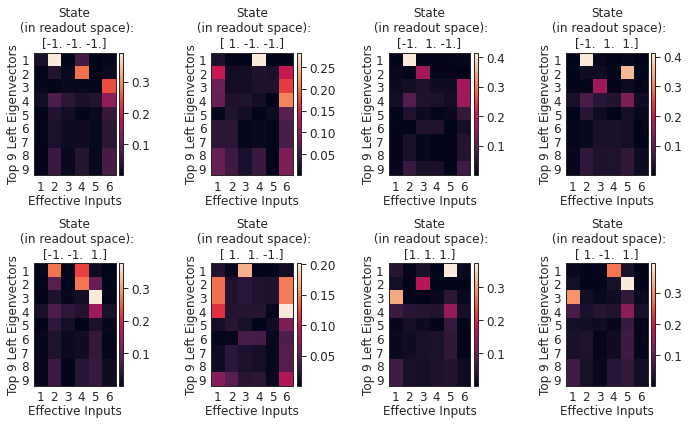

In [41]:
if reload_trained_model == True:
  import seaborn as sns
  sns.set_style("white")
  sns.set_context("paper")
  import matplotlib.gridspec as gridspec
  from matplotlib import cm
  from mpl_toolkits.axes_grid1 import make_axes_locatable



  fig = plt.figure(figsize=(10, 6))
  gs = fig.add_gridspec(2,4)

  fs=12
  lsize=12

  for i in range(4):

    ax0 = fig.add_subplot(gs[0,i])
    im=ax0.imshow(big_dot_norm[i][:9], norm=None)
 
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb =fig.colorbar(im,cax=cax)

    for t in cb.ax.get_yticklabels():
        t.set_fontsize(fs)

    ax0.set_xlabel('Effective Inputs', fontsize=fs,labelpad=1)
    ax0.set_ylabel('Top 9 Left Eigenvectors', fontsize=fs,labelpad=1)

    ax0.set_xticks([0,1,2,3,4,5])
    ax0.set_yticks([0,1,2,3,4,5,6,7,8])
    ax0.set_xticklabels([1,2,3,4,5,6],Fontsize=fs)
    ax0.set_yticklabels([1,2,3,4,5,6,7,8,9],Fontsize=fs)

    ax0.xaxis.set_tick_params(pad=.01)
    ax0.yaxis.set_tick_params(pad=.01)
    ax0.set_title('State\n (in readout space):\n'+str(np.round(hstar8_readout[i])), fontsize=fs)
  ##########################################################################
  for j in range(4):

    ax0 = fig.add_subplot(gs[1,j])

    i = j+4
    im=ax0.imshow(big_dot_norm[i][:9], norm=None)
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb =fig.colorbar(im,cax=cax)

    for t in cb.ax.get_yticklabels():
        t.set_fontsize(fs)

    ax0.set_xlabel('Effective Inputs', fontsize=fs,labelpad=1)
    ax0.set_ylabel('Top 9 Left Eigenvectors', fontsize=fs,labelpad=1)

    ax0.set_xticks([0,1,2,3,4,5])
    ax0.set_yticks([0,1,2,3,4,5,6,7,8])
    ax0.set_xticklabels([1,2,3,4,5,6],Fontsize=fs)
    ax0.set_yticklabels([1,2,3,4,5,6,7,8,9],Fontsize=fs)

    ax0.xaxis.set_tick_params(pad=.01)
    ax0.yaxis.set_tick_params(pad=.01)
    ax0.set_title('State\n (in readout space):\n'+str(np.round(hstar8_readout[i])), fontsize=fs)


  plt.tight_layout()  # Reduce whitespace

We see that essentially the only nonzero results correspond to the inputs that would flip the corresponding channel state. For example in the top row, 3rd from the right, state [-1,1,-1], the nonzero dot products correspond to the second, third, and sixth effective inputs. This corresponds to actual inputs of $[0,1], [1,0], [0,1]$ for each of the three channels respectively. According to the task definition, these are the inputs that would cause each of the three channels to flip its respective output state.  On the other hand, the first, fourth, and fifth effective inputs have no effect. This corresponds to actual inputs of  $[1,0], [0,1], [1,0]$ for the three channels respectively. According to the task definition, these inputs should not impact the states which is precisely what we see.

### Appendix: Readout state update mechanism

Note: this code will again only report complete results if each of the expansion points were selected above.

For this task, the system is expected to immediately update a channel output state on the same timestep that it receives a nonzero input that is different from the current channel state. We can observe how the system performs this update by taking the dot product between the different possible effective inputs and the readout matrix (a size $3\times100$ matrix), since the new addition of the effective input to the state is what the readout must use to cause the output to change immediately. 

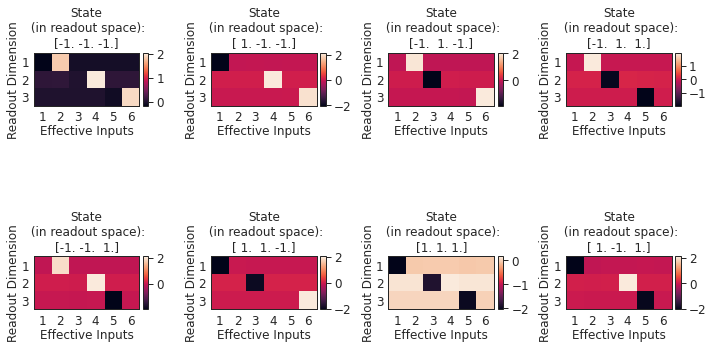

In [42]:
if reload_trained_model==True:
  fig = plt.figure(figsize=(10, 6))
  gs = fig.add_gridspec(2,4)
  # gs.update(wspace=0.7, hspace=0.001)

  fs=12
  lsize=12

  for i in range(4):

    #Compute dot product bewteen readout matrix and effective inputs
    dotprod = params['out']['W']@eff_inputs[i]+params['out']['b'][...,None]


    ax0 = fig.add_subplot(gs[0,i])
    im=ax0.imshow(dotprod, norm=None)

    divider = make_axes_locatable(ax0)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb =fig.colorbar(im,cax=cax)

    for t in cb.ax.get_yticklabels():
        t.set_fontsize(fs)

    ax0.set_xlabel('Effective Inputs', fontsize=fs,labelpad=1)
    ax0.set_ylabel('Readout Dimension', fontsize=fs,labelpad=1)

    ax0.set_xticks([0,1,2,3,4,5])
    ax0.set_yticks([0,1,2])
    ax0.set_xticklabels([1,2,3,4,5,6],Fontsize=fs)
    ax0.set_yticklabels([1,2,3,4,5],Fontsize=fs)

    ax0.xaxis.set_tick_params(pad=.01)
    ax0.yaxis.set_tick_params(pad=.01)
    ax0.set_title('State\n (in readout space):\n'+str(np.round(hstar8_readout[i])), fontsize=fs)
  ##########################################################################
  for j in range(4):
    #Compute dot product bewteen readout matrix and effective inputs
    i = j+4
    dotprod = params['out']['W']@eff_inputs[i]+params['out']['b'][...,None]

    ax0 = fig.add_subplot(gs[1,j])
    im=ax0.imshow(dotprod, norm=None)


    divider = make_axes_locatable(ax0)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb =fig.colorbar(im,cax=cax)

    for t in cb.ax.get_yticklabels():
        t.set_fontsize(fs)

    ax0.set_xlabel('Effective Inputs', fontsize=fs,labelpad=1)
    ax0.set_ylabel('Readout Dimension', fontsize=fs,labelpad=1)

    ax0.set_xticks([0,1,2,3,4,5])
    ax0.set_yticks([0,1,2])
    ax0.set_xticklabels([1,2,3,4,5,6],Fontsize=fs)
    ax0.set_yticklabels([1,2,3,4,5],Fontsize=fs)

    ax0.xaxis.set_tick_params(pad=.01)
    ax0.yaxis.set_tick_params(pad=.01)
    ax0.set_title('State\n (in readout space):\n'+str(np.round(hstar8_readout[i])), fontsize=fs)



  plt.tight_layout()  # Reduce whitespace

We see that the dot product is essentially only nonzero for the dimensions corresponding to the effective inputs that would cause the corresponding channel output state to flip.